# MPCS 58020 Homework 4

# Question 1 - Part a

Writing down the ARMA model in question for reference: 

$ X_t = 0.5X_{t-1} + 0.1 X_{t-2} + w_t + 0.5*w_{t-1} $

assuming noise ~ N(0,1)

fter debugging the homemade version of convolve(), the

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import kstest,ks_2samp,uniform,chi2,chi2_contingency
import scipy.stats
import pandas as pd
from scipy.signal import periodogram

# function used to simuate ARMA(2,1) and noise sequence
def populate_data(signal_length=100,interval=3,noise_sigma=1,noise_mu=0):

    x = [-interval + interval*2/signal_length*i \
         for i in range(signal_length)]

    # gaussian filter
    gt = [np.exp(-i**2) for i in x]

    # noise
    wt = np.random.normal(noise_mu,noise_sigma,signal_length)
    # initialize xt[0] and xt[1]. 
    xt = np.array([wt[0],wt[1]+0.5*wt[0]])
    # xt
    for i in range(2,signal_length):
        xt = np.append(xt,0.5*xt[i-1]+0.1*xt[i-2]+wt[i]+0.5*wt[i-1])
        
    return xt, gt

xt,gt = populate_data()

In [2]:
# home recipe convolve function! 

def convolve(f,g,method='valid'):
    pad_zero = np.zeros(len(f))
    g_padded = np.concatenate([g,pad_zero])
    g_flip = g_padded[::-1]
    
    pad_zero = np.zeros(len(g))
    f_padded = np.concatenate([f,pad_zero])
    
    result =np.zeros(len(f)+len(f)-1)
    
    for i in range(len(result)):
        result[i] = (g_flip[-(1+i):]*f_padded[0:(0+i+1)]).sum()
    
    if method =='valid':
        return result[int(len(result)/2)]
    elif method == 'full':
        return result

In [3]:
# LET's test it! 

a = np.array([1,2,3,6,7])
b = np.array([0,1,0.5,0.8,0.5])

print("result of homemade convolve:", convolve(a,b))
print("result of numpy convolve:", np.convolve(a,b,'valid'))
print("result of homemade convolve:", convolve(a,b,'full'))
print("result of numpy convolve:", np.convolve(a,b,'full'))

result of homemade convolve: 9.6
result of numpy convolve: [ 9.6]
result of homemade convolve: [  0.    1.    2.5   4.8   9.6  13.4   9.8   8.6   3.5]
result of numpy convolve: [  0.    1.    2.5   4.8   9.6  13.4   9.8   8.6   3.5]


In [4]:
# Let's try it with the X_t and W_t in question 

In [40]:
# convolve xt with gt defined above: 
xt,gt = populate_data()
print("result of homemade convolve:", convolve(xt,gt))
print("result of numpy convolve:", np.convolve(xt,gt,'valid'))

result of homemade convolve: -10.1299327647
result of numpy convolve: [-10.12993276]


In [193]:
# try 1000 - 100000 

# NOTICE: when signal length = 100000, it takes about 90 second for homemade version of convolve()
# on my laptop. I don't recommend running 100000, because it took about 30 minutes for me to 
# run it with homemade version of convolve. 

# 1000
xt,gt = populate_data(signal_length=1000)
print("signal length = 1000")
start = time.time()
print("result of homemade convolve:", convolve(xt,gt))
print("homemade convolve takes",time.time()-start," seconds to run\n")
start = time.time()
print("result of numpy convolve:", np.convolve(xt,gt,'valid'))
print("numpy.convolve() takes",time.time()-start," seconds to run\n")

# 10000
xt,gt = populate_data(signal_length=10000)
print("signal length = 10000")
start = time.time()
print("result of homemade convolve:", convolve(xt,gt))
print("homemade convolve takes",time.time()-start," seconds to run\n")
start = time.time()
print("result of numpy convolve:", np.convolve(xt,gt,'valid'))
print("numpy.convolve() takes",time.time()-start," seconds to run\n")

# 100000
xt,gt = populate_data(signal_length=100000)
print("signal length = 100000")
start = time.time()
print("result of homemade convolve:", convolve(xt,gt))
print("homemade convolve takes",time.time()-start," seconds to run\n")
start = time.time()
print("result of numpy convolve:", np.convolve(xt,gt,'valid'))
print("numpy.convolve() takes",time.time()-start," seconds to run\n")

#100000
xt,gt = populate_data(signal_length=1000000)
print("signal length = 1000000")
start = time.time()
print("result of homemade convolve:", convolve(xt,gt))
print("homemade convolve takes",time.time()-start," seconds to run\n")
start = time.time()
print("result of numpy convolve:", np.convolve(xt,gt,'valid'))
print("numpy.convolve() takes",time.time()-start," seconds to run\n")

signal length = 1000
result of homemade convolve: -147.56435709
homemade convolve takes 0.031246185302734375  seconds to run

result of numpy convolve: [-147.56435709]
numpy.convolve() takes 0.0  seconds to run



KeyboardInterrupt: 

# Question 1 - Part b

Below are results/performance comparisons between FFT(convolution(ARMA * filters)), both using numpy.convolve() and my own version of convolve(), and  FFT(ARMA) * FFT(filters). As you could see: 

FFT(ARMA) * FFT(filters) are the fastest 

FFT(convolution(ARMA * filters)) using numpy.convolve() is second 

FFT(convolution(ARMA * filters)) using my own version of convolve() is slowest

The three results are very close to each other. 

In [70]:
# Let's take signal length = 10000 as example

xt,gt = populate_data(signal_length=10000)

# 1
# this is to compute FFT(convolution of ARMA * filters)
# using numpy.convolve()
start = time.time()
physical_space_numpy_package = np.fft.fft([np.convolve(xt,gt,'full')])
print("FFT of Convolution using numpy.convolve() takes",time.time()-start," seconds to run\n")

# 2
# this is to compute FFT(convolution of ARMA * filters)
# using  homemade convolve()
start = time.time()
physical_space_homemade_convolve = np.fft.fft([convolve(xt,gt,'full')])
print("FFT of homemade Convolution using takes",time.time()-start," seconds to run\n")

# 3
# this is to compute FFT (ARMA) * FFT(filters) 
start = time.time()
fourier_space = np.fft.fft(xt)*np.fft.fft(gt)
print("Product of two FFT takes",time.time()-start," seconds to run\n")

# Summary: 
# To keep it short and readable, I will print just a few sample of the three results.
print("samples of FFT of Convolution using numpy.convolve()")
print(physical_space_numpy_package[0][0])
print("samples of FFT of homemade Convolution")
print(physical_space_homemade_convolve[0][0])
print("samples of Product of two FFT")
print(fourier_space[0])

FFT of Convolution using numpy.convolve() takes 0.09375238418579102  seconds to run

FFT of homemade Convolution using takes 0.5297060012817383  seconds to run

Product of two FFT takes 0.0  seconds to run

samples of FFT of Convolution using numpy.convolve()
(57031.5840021+0j)
samples of FFT of homemade Convolution
(57031.5840021+0j)
samples of Product of two FFT
(57031.5840021+0j)


# Question 2 

### (a)
f(t) = $Ae^{-at^2}$

According to wikipedia, fourier transform is:

$A\sqrt{\frac{\pi}{a}}e^{-\frac{(\pi\omega)^{2}}{a}}$

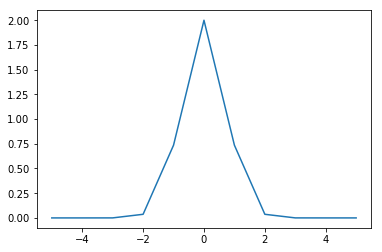

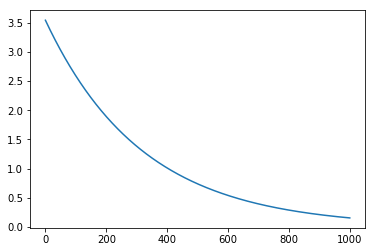

In [4]:
a = 1 
A = 2
t = [i for i in range(-5,6)]
f = [A*np.exp(-a*(i**2)) for i in t]
plt.plot(t,f)
print("plotting of Original function\n")
plt.show()

omega = [i*0.001 for i in range(0,1000)]
f_fft = np.array([A*np.sqrt(np.pi/a)*np.exp(-(np.pi*i)/a) for i in omega]) 
plt.plot(f_fft)
print("plotting of Fourier Transform\n")
plt.show()

### (b)
f(t) = $sin(2\pi vt) + cos(2\pi vt)$

According to the notes, fourier transform is: 

$\frac{[\delta(\omega+s)+\delta(\omega-s)]}{2}+\frac{i[\delta(\omega+s)+\delta(\omega-s)]}{2}$

plotting of Original function



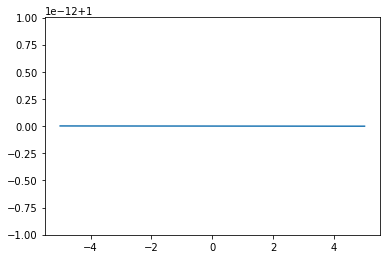

plotting of Fourier Transform



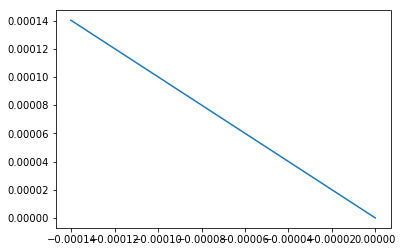

In [10]:
# plot original function:
t = np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5])
s = 1
f =[np.cos(2*np.pi*s*i) + np.sin(2*np.pi*s*i) for i in t]
plt.plot(t,f)
print("plotting of Original function\n")
plt.show()

# plot Fourier transform
def dirac(x,a=20):
    return np.exp(-(x/a)**2)/(a*np.sqrt(np.pi))

omega = [i*0.001 for i in range(0,1000)]
f_transform = [ (dirac(i+s)-dirac(i-s))/2 +(dirac(i+s)-dirac(i-s))/2j for i in omega]

real = []
image = []
for i in f_transform:
    real.append(i.real)
    image.append(i.imag)

plt.plot(real,image)
print("plotting of Fourier Transform\n")
plt.show()

## (c)

It's from our notes that $\gamma(t) = \int_{-\infty}^{\infty} f(t')f(t+t')dt$ and $\hat{\gamma}(\omega) = |\hat{f}(\omega)|^2$, for any real valued function. Although I have no idea how it's derived, let me just take it as granted. Since it's a Fourier Transform of a real function, whose plotting looks for different functions, for now I will skip it.

### (d)

I was confused by this one, seems like many fourier transform example applies to it, but after a lengthy thought, I chose the third one, which treats f(t) = 1*1/a, so 1 correspond to sinc(a$\pi\omega$) and 1/a is a constant. So totally, if writting sinc() function in plain format, mounts : 

Fourier Transform: $\frac{sin(a\pi \omega)}{a^2\pi \omega}$

Hopefully it's correct.

plotting of Original function



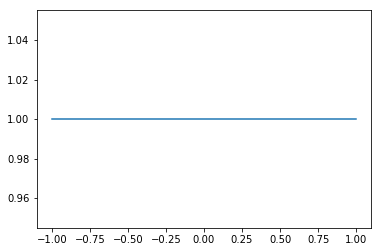

plotting of Fourier Transform



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


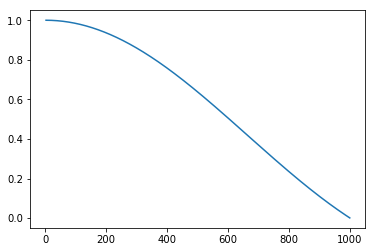

In [11]:
# plot

a = 1 

t = np.linspace(-1/a,1/a,1000)
s = 1
f =[1/a for i in t]
plt.plot(t,f)
print("plotting of Original function\n")
plt.show()

omega = [i*0.001 for i in range(0,1000)]
f_fft = np.array([np.sin(a*np.pi*i)/(a**2*np.pi*i) for i in omega]) 

# according to wiki, sinc(x) = 1 when x =0
f_fft = np.concatenate([np.array([1]),f_fft])

plt.plot(f_fft)
print("plotting of Fourier Transform\n")
plt.show()

# Question 3


Take $X_t = 0.4X_{t-1} + 0.5X_{t-2} + 0.5W_{t-1} + 0.25W_{t-2} + W_t$ 

I've verified that this ARMA(2,2) is both stationary and invertible by hand. For now, I will skip the verification.  

Obsevation in (b): A filter function g can be used to extract signals from the ARMA(2,2) sequence X_t by enhancing the spectrum of the ARMA sequence. So as can been seen in part (d), the filter enhances signal on both side of the original signal. So in part (b), the enhanced signal is amplified on both side. Also, no matter what original signal sequence is used, the Fourier transform on the convolution of filters and signal will behave the same such that two sides of the convolution is amplified, middle interval stays relatively stable. 

We could also produce other filters(amplifier) to perform a different kind of enhancement.  

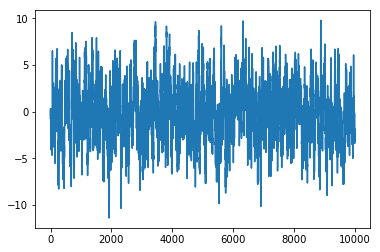

In [250]:
# Plot X_t
n = 10000

wt = np.random.normal(0,1,n)
# initialize xt[0] and xt[1]. 
xt = np.array([wt[0],wt[1]+0.5*wt[0]+0.5*xt[0]])

for i in range(2,n):
    xt = np.append(xt,0.4*xt[i-1]+0.5*xt[i-2]+wt[i]+0.5*wt[i-1]+0.25*wt[i-2])

# try to enhance a white noise signal 
# xt = np.random.normal(0,1,n)

plt.plot(xt)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


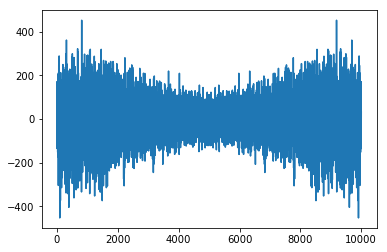

In [235]:
# Plot filtered x_t

t= np.array([i for i in range(1,10000)])
t= np.concatenate([t,np.zeros(n-len(t))])

gt = np.array([-2*i*np.exp(-(i**2)/2) for i in t])

# using product of FFT(f)*FFT(g)
filtered_xt=np.fft.fft(xt)*np.fft.fft(gt)
plt.plot(filtered_xt)
plt.show()

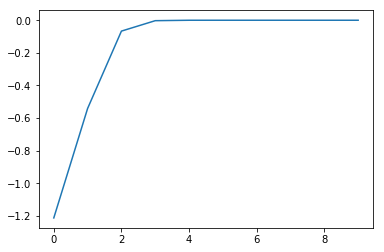

In [236]:
# Plot filter in physical space: 

# Only plottinf the first values because it's all very close to 0 afterwards
plt.plot(gt[:10])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


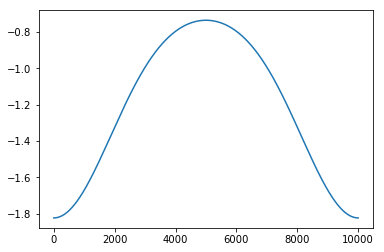

In [237]:
# Plot filter in fourier space:
plt.plot(np.fft.fft(gt))
plt.show()

# Question 4

ARMA(2,2) function in Question 3: 

$X_t = 0.4X_{t-1} + 0.5X_{t-2} + 0.5W_{t-1} + 0.25W_{t-2} + W_t$ 

#### Derivation: 
autocovariance function can be written as: $ \gamma(h) = 0.4\gamma(h-1) + 0.5\gamma(h-2) $ 

According to formula (3.48) and (3.40) in textbook, when $\sigma_{\omega}^2 =1$, defined when creating noise sequence, initial condition should be:

when h = 2, $\gamma(2) - 0.4\gamma(1) - 0.5\gamma(0) = 0.25$

when h = 1, $\gamma(1) - 0.4\gamma(0) - 0.5\gamma(1) = 0.5*1+0.25*0.9 =0.75 $

when h = 0, $\gamma(0) - 0.4\gamma(1) - 0.5\gamma(2) = (1*1+0.5*0.9+0.25*1.15) = 1.7375$

Solving for $\gamma(0), \gamma(1), \gamma(2)$, we get 

$\gamma(0) = 10.22$

$\gamma(1) = 9.68$

$\gamma(2) = 9.23$

##### So autocovariance $\gamma(h)$ can be define as a sequence like : 

$ \gamma(h) = 0.4\gamma(h-1) + 0.5\gamma(h-2) $, with initial condition as $\gamma(0) = 10.22$, $\gamma(1) = 9.68$ and $\gamma(2) = 9.23$

and ACF function thus should be $\rho(h) = \gamma(h) / \gamma(0)$

So based on the calculation shown above, p(0) ~ ph(5) should be = [1,0.947,0.903,0.8348,0.7855]

### Notice: the calculation above are manually derived. So the precision will be off a little bit to speed up the process. 

To keep the work minimum, I will compare the results with a lag = 5. 

In [292]:
# define a ACF function to check results. 
def acf(series, h): 
    series_mean = series.mean()
    r_0 = series.var()    
    return sum((series[h:]-series_mean)*(series[:len(series)-h]-series_mean))/(len(series))/series.var()

# gathering results 
hand_cal = np.array([1,0.947,0.903,0.8348,0.7855])
acf_result = np.array([acf(xt,0),acf(xt,1),acf(xt,2), acf(xt,3),acf(xt,4)])
print("ACF based acf function are \n",acf_result)
print("ACF by hand calculation \n",hand_cal)

ACF based acf function are 
 [ 1.          0.94020233  0.89604319  0.82213198  0.77026275]
ACF by hand calculation 
 [ 1.      0.947   0.903   0.8348  0.7855]


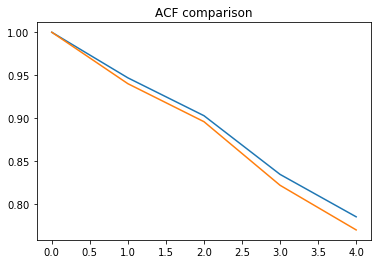

In [291]:
# plot comparision 

plt.plot(hand_cal)
plt.plot(acf_result)
plt.title("ACF comparison")
plt.show()

# Question 5 - Shumway 4.2
## (a)
Writing Down the two functions for references

$Z_1 = Acos(\phi)$ 
$Z_2 = Asin(\phi)$

the idea to solve this problem is first simulating the two sequences, $\phi$(phi_calculated in code below) and $A^2$(A_square in code below), and then use KS-test to compare the two sequences with hypothetical distribution, which is chi-square and uniform distribution. As you could see, ks-test shows that it can not reject the null hypothesis that $\phi$ (phi_calculated below) is identical to a uniform random numbers sample on($-\pi/2,\pi/2$), why just $\pi/2$ rather than $\pi$?, I will give explanation later, and it can neither reject the null hypothesis that $A^2$ is identical to chi-square distribution with degree of freedom 2. 

A_square plotting:



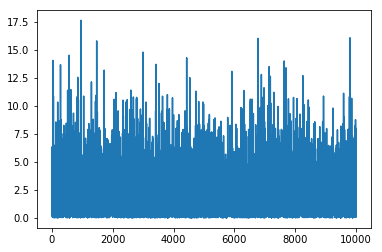

phi plotting:



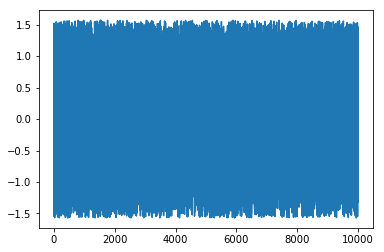

In [123]:
A=1

# generate 2 sets of random normal numbers, each 10000 length 
z1 = np.random.normal(0,1,10000)
z2 = np.random.normal(0,1,10000)

# compute A Squared
A_square = np.array([z1[i]**2 + z2[i]**2 for i in range(len(z1))])
# compute phi
phi_calculated = np.arctan(z2/z1)

# plotting
# notice: to get higher resolution, please reduct the number of random z1 and z2 to 500 below.
print("A_square plotting:\n")
plt.plot(A_square)
plt.show()
print("phi plotting:\n")
plt.plot(phi_calculated)
plt.show()
# orange represents phi

In [121]:
# create a random uniform number within [-pi/2,pi/2]
uniform_benchmark = np.random.uniform(-np.pi/2,np.pi/2,10000)

# use ks 2 sample test to test if calculated phi is identical to random uniform number within [-pi/2,pi/2]
print("test if phi_calculated is uniform distributed")
print("According to the document, null hypothesis of ks_2samp() is the two sample are identical\n")
ks_2samp(phi_calculated,uniform_benchmark)

According to the document, null hypothesis of ks_2samp() is the two sample are identical



Ks_2sampResult(statistic=0.0071999999999999981, pvalue=0.95719183704582544)

In [120]:
# ks-test if A_square is identical to Chi-square distribution with df = 2
print("test if A_square is chi-square distributed")
print("According to the document, null hypothesis of kstest() is the sample is identical to chi-square distribution")
kstest(A_square,'chi2',[2])

According to the document, null hypothesis of kstest() is the sample is identical to chi-square distribution


KstestResult(statistic=0.0093698134326555271, pvalue=0.34373324148428697)

### Chi-square independence test of $\phi$ and $A^2$

As can be seen, Chi-square independence test can not reject the null hypothesis that $\phi$(phi_calculated in code below) and $A^2$(A_square in code below) are independent

In [193]:
# below I'm using Chi-square independence test to test if phi and A_square are independent with each other
# based on the observed cross frequency table.  

A_square=pd.Series(A_square.transpose())
phi_calculated=pd.Series(phi_calculated.transpose())

# create frequency table 
a = pd.concat([A_square,phi_calculated],axis=1)

# fetch p-value
chi2, pvalue, some, some2 = chi2_contingency(pd.crosstab(a[a.columns[0]],a[a.columns[1]]))

print("null hypothesis of Chi-square independence test is: the two samples are independent with each other\n")
print("P-value of the test:",pvalue,"\n")

null hypothesis of Chi-square independence test is: the two samples are independent with each other

P-value of the test: 0.239742737224 



### NOTICE: There is an misleading part in Question 4.2, where it says that $\phi$ is uniformly distributed on ($-\pi,\pi$). Because the codomain of arctan function ($tan^{-1}$), is only ($-\pi/2,\pi/2$). So it can never reaches ($-\pi,\pi$). The following plotting of $\phi$ also confirms that. However, intuitively, this does not means the plotting or the statement that $\phi$ is uniformly distributed on ($-\pi,\pi$) is wrong, because  in polar coordinates, $\phi$ must be within ($-\pi,\pi$), which totally sums to be 2$\pi$, 360 degree. Also,  tan(135 degree) = - tan(45 degree). This indicates that, assuming we have proved that $\phi$  is uniform within ($-\pi/2,\pi/2$), then for $\phi$ larger than 90 degree, it's also a uniform distribution. because it's equal to negative of a uniform random variable, which should be also uniform variable. Same applies to when  $\phi$ smaller than negative 90 degree.  

### (b)

z1 plotting:



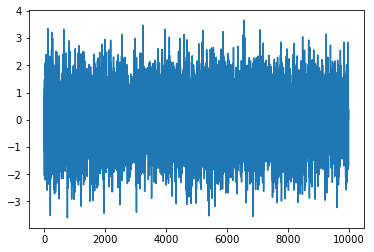

z2 plotting:



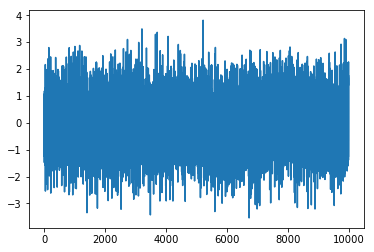

In [174]:
### (b) - same logic, KS-test

A_square = np.random.chisquare(2,10000)
phi = np.random.uniform(-np.pi,np.pi,10000)

z1 = np.array([np.sqrt(A_square[i])*np.cos(phi[i]) for i in range(len(A_square))])
z2 = np.array([np.sqrt(A_square[i])*np.sin(phi[i]) for i in range(len(A_square))])

print("z1 plotting:\n")
plt.plot(z1)
plt.show()

print("z2 plotting:\n")
plt.plot(z2)
plt.show()

In [156]:
# a standard normal random number sample
normal_sample = np.random.normal(0,1,10000)

# KS test
print("test if z1 is standard normal distributed\n")
print("ks_2samp null hypothese: the two sample is identically distributed\n")
print(ks_2samp(z2,normal_sample))
print("test if z1 is standard normal distributed\n")
print("kstest null hypothese: the input sample is identically distributed as std normal distribution\n")
print(kstest(z1,'norm'))

test if z1 is standard normal distributed

ks_2samp null hypothese: the two sample is identically distributed

Ks_2sampResult(statistic=0.00880000000000003, pvalue=0.83197723748137786)
test if z1 is standard normal distributed

kstest null hypothese: the input sample is identically distributed as std normal distribution

KstestResult(statistic=0.011052033187598398, pvalue=0.17369435346735426)


### indepdence test on Z1 and Z2

As can be seen below, the Chi-square independence can not reject the null hypothesis that Z1 and Z2 are independent with each other. 

In [192]:
# below I'm using Chi-square independence test to test if Z1 and Z2 are independent with each other
# based on the observed cross frequency table.  

z1=pd.Series(z1.transpose())
z2=pd.Series(z2.transpose())

# create frequency table 
a = pd.concat([z1,z2],axis=1)
# fetch p-value
chi2, pvalue, some, some2 = chi2_contingency(pd.crosstab(a[a.columns[0]],a[a.columns[1]]))

print("null hypothesis of Chi-square independence test is: the two samples are independent with each other\n")
print("P-value of the test:",pvalue,"\n")


null hypothesis of Chi-square independence test is: the two samples are independent with each other

P-value of the test: 0.239742737224 



## Question 6 - Shumway 4.4

### (a)

E($\omega$) = 0 

$\gamma_\omega(s,t)$ = 1 when s=t, 

$\gamma_\omega(s,t)$ = 0 when s!=t, because white noise is assumed to be iid and standard normal.  

white noise is always stationary because it has fixed mean and variance.


Following example 3.4 of textbook, 

$E(x_t) = E(w_t - \theta*w_{t-1}) = 0 - 0 = 0$ 

$\gamma(0) = Var(X_t) = Var(\omega) * \theta^2*Var(\omega) = 1 + \theta^2$  

$\gamma(1) =\gamma(-1) = -\theta*Var(\omega) = -\theta$

$\gamma(n) = 0$, when n > 1 

MA model is always weakly stationary, it is a linear combination of white noise whose first two moments are always constant. 


### (b) 



Following example 4.5 and formula (4.12) of textbook, combining part(a)'s result, we have 

$f(\omega) = -\theta*e^{2\pi i \omega} + 1 + \theta^2 -\theta*e^{-2\pi i \omega}  = 1 + \theta^2 - \theta*cos(2 \pi \omega)$

##### NOTICE: I was confused by these terms "spectrum", "power spectrum", "spectrum density"... Here, I assume when the question asks to derive "Power specturm" , it refers to spectrum density that's given by (4.12), though to me it sounds very odd, because spectrum power means somehting like an energy stuff, but density means how much energy each unit contains. But after reading through section 4.3 of textbook, there is no other definition on power spectrum. 

# Question 7 - Shumway 4.8

notice I haven't found any documents regarding how R implement the spec.pgram(), when I use formula (4.18) from textbook, the plotting looks very odd. It only looks identical to the plotting given by R when subtract mean value of the sunspotz sequence from the raw data, as formular (4,21) of textbook illastrates. That's very odd. 

Notice: the plotting of Periodogram is full, so it has some mirror effects, that's symmetric to the middle point of the horizontal axis. 

For confidence interval, I'm just computing the confidence interval of the max spectrum value shown on the peridogram as an illastration. 

The following periodogram show potential max impluse of squared amplitudes at relatively high frequenct, as shown by the plot of original time series. It also suggests a acyclic behavior at low hertz, at least somehow. 

plot of original time series


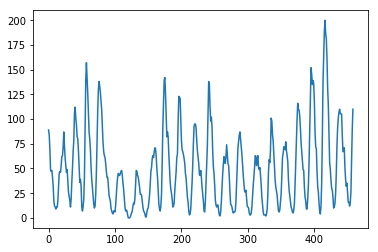

plot of periodogram


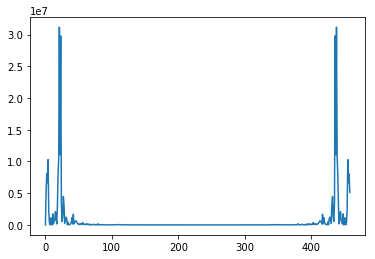

In [85]:
xt = np.loadtxt('C:\\Users\\zheny\\Downloads\\sunspotz_series.txt')
print("plot of original time series")
plt.plot(xt)
plt.show()
xt = xt - np.mean(xt)
xt_periodogram = np.abs(np.abs(np.fft.fft(xt)))** 2
plt.plot(xt_periodogram)
print("plot of periodogram")
plt.show()

In [76]:
# compute confidence interval of the max spectrum value

df = 2
# max value's index in spectrum
max_value_index = list(xt_periodogram).index(xt_periodogram.max())

quantile_score = chi2.ppf([0.025,  0.975], df)

print("95% confidence interval of the max value in periodogram of sunspotz data is:\n")
print(2* xt_periodogram[max_value_index]/quantile_score)

95% confidence interval of the max value in periodogram of sunspotz data is:



array([  1.23021533e+09,   8.44331074e+06])

# Question 8 - Shumway 4.9 

## (a) 

seems like this question is identical to question 7.. So same logic used here. 

Notice: the plotting of Periodogram is full, so it has some mirror effects, that's symmetric to the middle point of the horizontal axis. 

Observation: The following periodogram suggests a nonsinusoidal at high frequency, yet cyclic at low frequency, because there is a peak in the periodogram at low frequency. Also there are also some peaks at some multiples of the first peak frequency with a decaying impluse, so this suggests a nonsinusoidal effect. In a nutshell, i would say it's sinusoidal at low, while nonsinusoidal at high frequency. 

plot of original time series


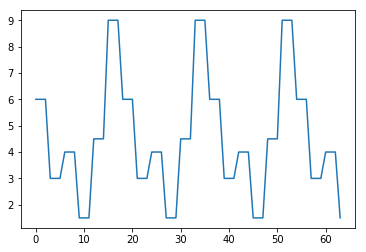

plot of periodogram


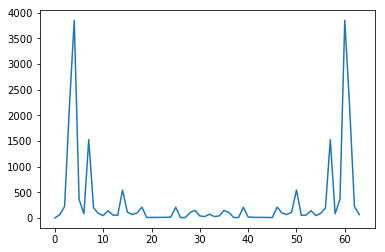

In [83]:
xt = np.loadtxt('C:\\Users\\zheny\\Downloads\\salt.txt')
print("plot of original time series")
plt.plot(xt)
plt.show()

xt = xt - np.mean(xt)
xt_periodogram = np.abs(np.abs(np.fft.fft(xt)))** 2
plt.plot(xt_periodogram[0:100])
print("plot of periodogram")
plt.show()

In [78]:
# confidence interval
df = 2
# max value's index in spectrum
max_value_index = list(xt_periodogram).index(xt_periodogram.max())

quantile_score = chi2.ppf([0.025,  0.975], df)

print("95% confidence interval of the max value in periodogram of sunspotz data is:\n")
print(2* xt_periodogram[max_value_index]/quantile_score)

95% confidence interval of the max value in periodogram of sunspotz data is:

[ 152236.9142518     1044.84437919]


### (b)

Notice: the plotting of Periodogram is full, so it has some mirror effects, that's symmetric to the middle point of the horizontal axis. 

Observation: The following plot suggests a sinusoidal behavior at low frequency, while nonsinusoidal at higher frequency, as confirmed by the time series plotting. 

plot of original time series


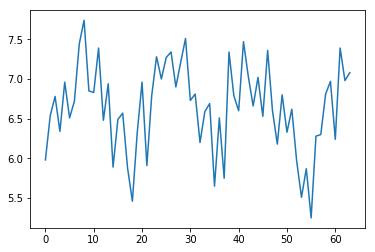

plot of periodogram


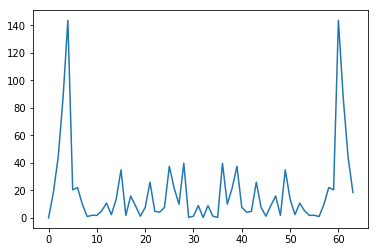

In [84]:
xt = np.loadtxt('C:\\Users\\zheny\\Downloads\\saltemp.txt')
print("plot of original time series")
plt.plot(xt)
plt.show()
xt = xt - np.mean(xt)
xt_periodogram = np.abs(np.abs(np.fft.fft(xt)))** 2
plt.plot(xt_periodogram[0:100])
print("plot of periodogram")
plt.show()


In [80]:
# confidence interval of the max spectrum
df = 2
# max value's index in spectrum
max_value_index = list(xt_periodogram).index(xt_periodogram.max())

quantile_score = chi2.ppf([0.025,  0.975], df)

print("95% confidence interval of the max value in periodogram of sunspotz data is:\n")
print(2* xt_periodogram[max_value_index]/quantile_score)

95% confidence interval of the max value in periodogram of sunspotz data is:

[ 5680.44303945    38.98646403]
